# IMPORTS

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
import plotting
import lstm
import metrics
import train
import torch.nn as nn
import progressive_blocks
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam


c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and plot train

Any missing value: V2    False
dtype: bool
all training set length:  48000


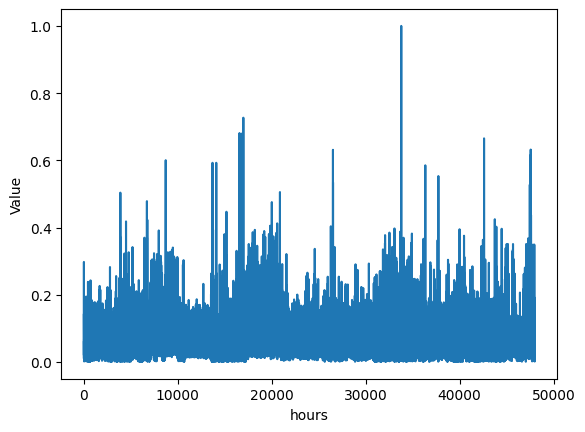

In [2]:
path="Models/M4/"

training_set = pd.read_csv('./Datasets/M4-Dataset/Train/Monthly-train.csv')

training_set = training_set.iloc[:,1:2] #electricity values in time
any_missing_train = training_set.isnull().any()
print("Any missing value:",any_missing_train)
print("all training set length: ",len(training_set))

sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)

plotting.plot_dataset(training_set, x_axis="hours", y_axis="Value")

## Load and plot test

Any missing value: V2    False
dtype: bool
all testing set length:  48000


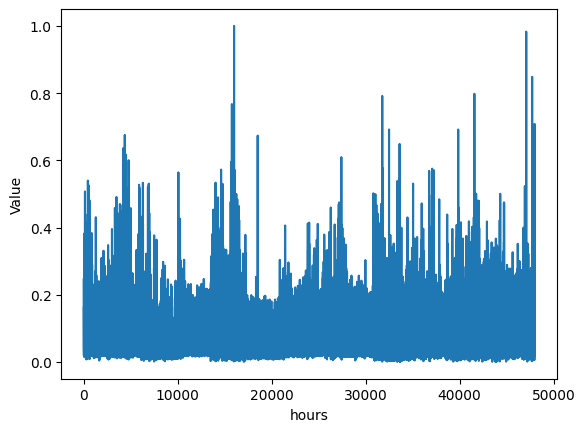

In [3]:
testing_set = pd.read_csv('./Datasets/M4-Dataset/Test/Monthly-test.csv')

testing_set = testing_set.iloc[:,1:2] #electricity values in time
any_missing_test = testing_set.isnull().any()
print("Any missing value:",any_missing_train)
print("all testing set length: ",len(testing_set))

sc = MinMaxScaler()
testing_set = sc.fit_transform(testing_set)

plotting.plot_dataset(testing_set, x_axis="hours", y_axis="Value")

## Create sequences for train

In [4]:
seq_length = 512 #it is tau in the paper

train_set=training_set[:42500]
print("train_set.shape:",train_set.shape)

x_train, y_train = utils.sliding_windows(train_set, seq_length)
trainX=torch.Tensor(np.array(x_train))
print("trainX.shape:",trainX.shape)
size=trainX.size(0)

sequences_train=utils.real_seq(training_set,seq_length)
sequences_train=sequences_train[:size]

sequences_train=torch.Tensor(sequences_train)
sequences_train.unsqueeze(0).unsqueeze(1)
sequences_train=sequences_train.permute(0,2,1)
print("Sequences_train.shape",sequences_train.shape)

train_set.shape: (42500, 1)
trainX.shape: torch.Size([41987, 512, 1])
Sequences_train.shape torch.Size([41987, 1, 512])


## Create sequences for test

In [5]:
test_set=testing_set[:42500]
print(test_set.shape)

x_test, y_test= utils.sliding_windows(test_set, seq_length)
testX=torch.Tensor(np.array(x_test))
print("testX.shape:",testX.shape)
size=testX.size(0)

sequences_test=utils.real_seq(testing_set,seq_length)
sequences_test=sequences_test[:size]

sequences_test=torch.Tensor(sequences_test)
sequences_test.unsqueeze(0).unsqueeze(1)
sequences_test=sequences_test.permute(0,2,1)
print("Sequences_test.shape",sequences_test.shape)

(42500, 1)
testX.shape: torch.Size([41987, 512, 1])
Sequences_test.shape torch.Size([41987, 1, 512])


### Test loader for evaluations

In [6]:
test= TensorDataset(testX, sequences_test)
test_loader = DataLoader(test, batch_size=347, shuffle=False)
embedder=torch.load("Models/Embedder/embedder_model.pt")

In [7]:
utils.create_folder(path)

Directory already exists: Models/M4/


## PSA-GAN

Cuda enabled: using GPU
Directory already exists: Models/M4/PSA-GAN/

Starting training: PSA-GAN
Total Epochs: 27 
Blocks to add with fade: 2
Timestamp to add blocks: 9
Fade-in True
ML True
SA True
[Epoch 1/27] [Batch 1/121] [D loss: 0.653687] [G loss: 0.881541] [Fade-in: 1.000000] [FID: 0.000281]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 2/121] [D loss: 0.653273] [G loss: 0.825086] [Fade-in: 1.000000] [FID: 0.000184]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 3/121] [D loss: 0.652690] [G loss: 0.807223] [Fade-in: 1.000000] [FID: 0.000191]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 4/121] [D loss: 0.652105] [G loss: 0.790647] [Fade-in: 1.000000] [FID: 0.000189]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 5/121] [D loss: 0.651523] [G loss: 0.796395] [Fade-in: 1.000000] [FID: 0.000160]
[Epoch 1/27] [Batch 6/121] [D loss: 0.650943] [G loss: 0.785825] [Fade-in: 1.000000] [FID: 0.000207]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 7/121]

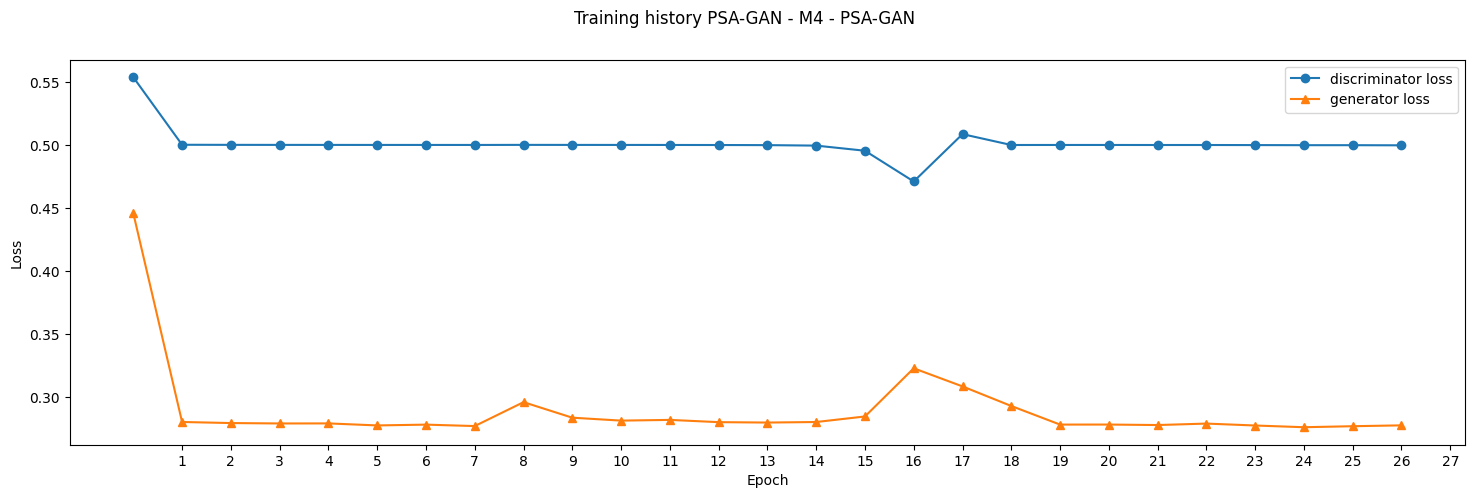

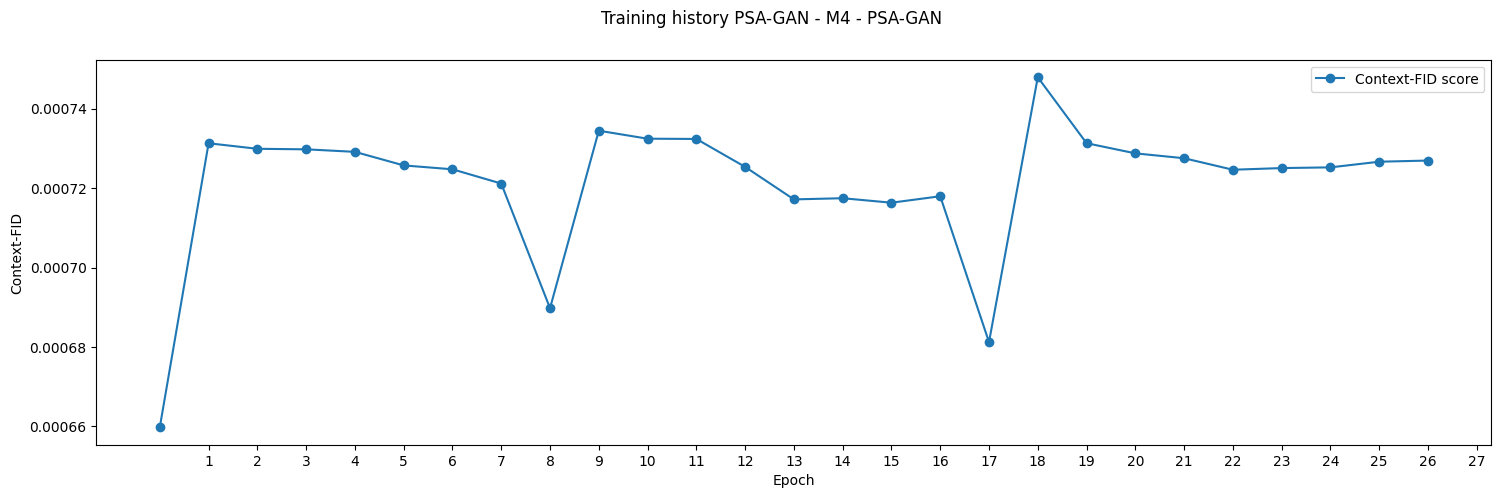

In [8]:
%%time

name_model="PSA-GAN"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=347,
    discriminator_lr=0.0005,
    generator_lr=0.0005,
    num_epochs=12,
    blocks_to_add=2,
    timestamp=4,
    ml=True,
    fade_in=True,
    sa=True,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)

100%|██████████| 121/121 [00:05<00:00, 22.65it/s]


PSA-GAN  NRMSE: 0.0006549214012920856


100%|██████████| 121/121 [01:15<00:00,  1.61it/s]

PSA-GAN  FID = 3.497125020648639e-06 +- 3.497125020648639e-06  
std: 0.0
NRMSE on test set:  tensor(0.2376)


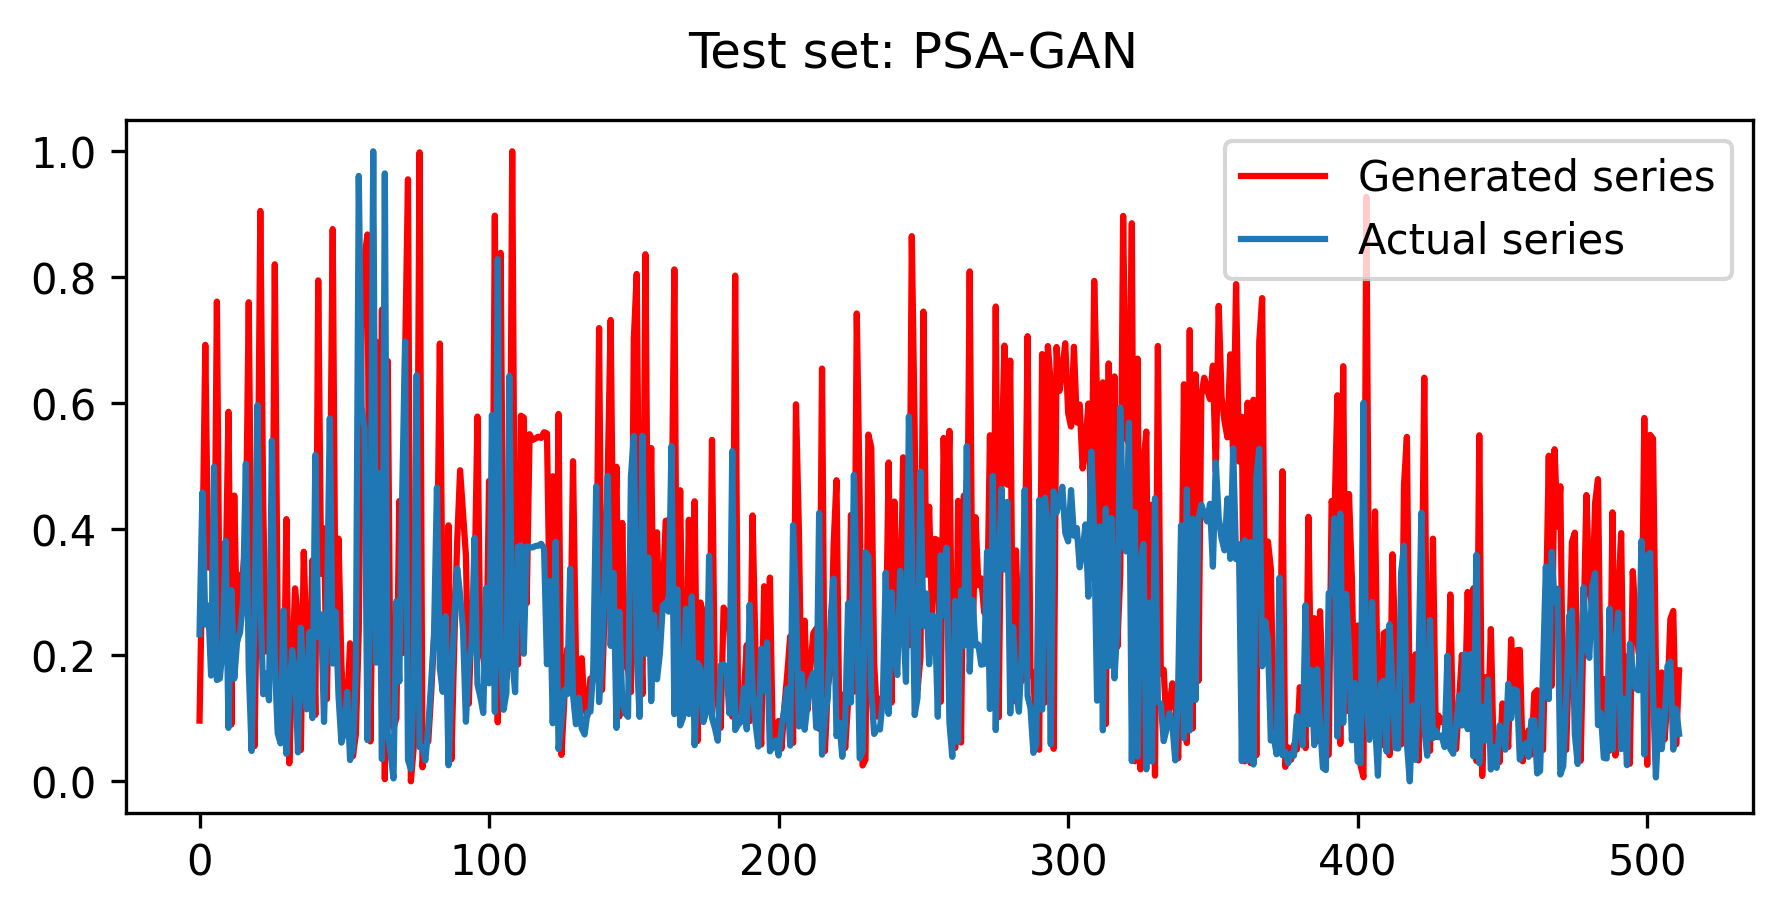

In [9]:
nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print(name_model," FID =",mean,"+-",upper," \nstd:",std_dev)

plotting.prediction_test(seq_length, 347, test_set, testX, G, name_model)

In [10]:
utils.free_gpu(G)

## w/o Fade-in

Cuda enabled: using GPU
Directory already exists: Models/M4/wo_fade/

Starting training: wo_fade
Total Epochs: 27 
Blocks to add with fade: 2
Timestamp to add blocks: 9
Fade-in False
ML True
SA True
[Epoch 1/27] [Batch 1/121] [D loss: 1.556840] [G loss: 1.863472] [Fade-in: 1.000000] [FID: 0.000320]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 2/121] [D loss: 1.592221] [G loss: 1.759838] [Fade-in: 1.000000] [FID: 0.000172]
[Epoch 1/27] [Batch 3/121] [D loss: 1.566834] [G loss: 1.709884] [Fade-in: 1.000000] [FID: 0.000210]
[Epoch 1/27] [Batch 4/121] [D loss: 1.542907] [G loss: 1.668585] [Fade-in: 1.000000] [FID: 0.000208]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 5/121] [D loss: 1.520471] [G loss: 1.631781] [Fade-in: 1.000000] [FID: 0.000154]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 6/121] [D loss: 1.497597] [G loss: 1.589805] [Fade-in: 1.000000] [FID: 0.000223]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 7/121] [D loss: 1.474796] [G loss: 1.55

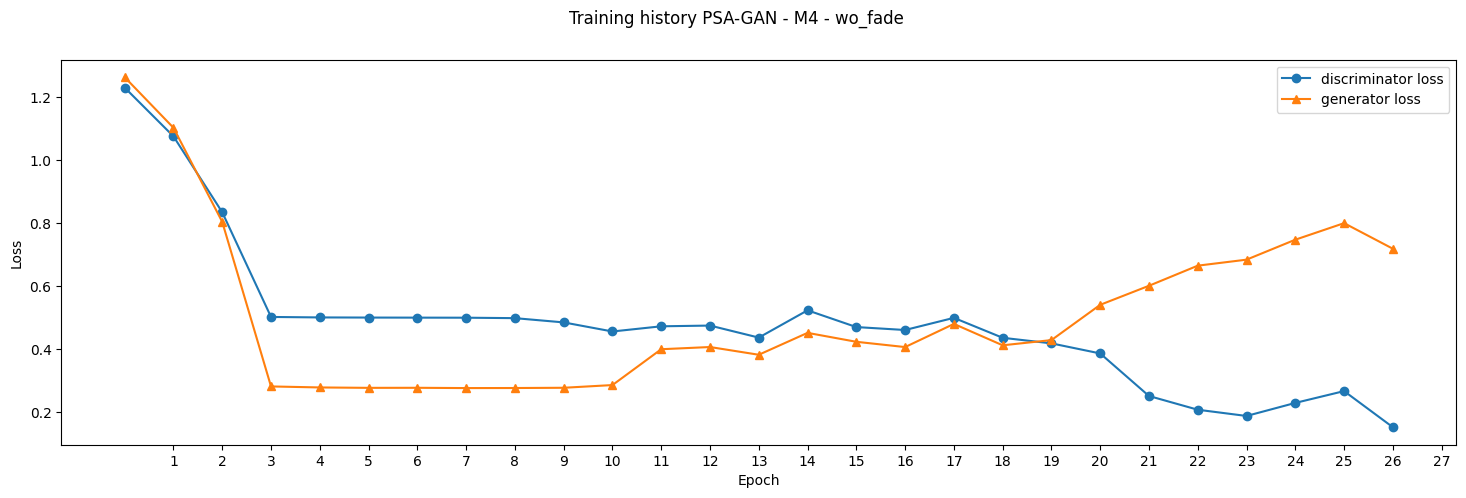

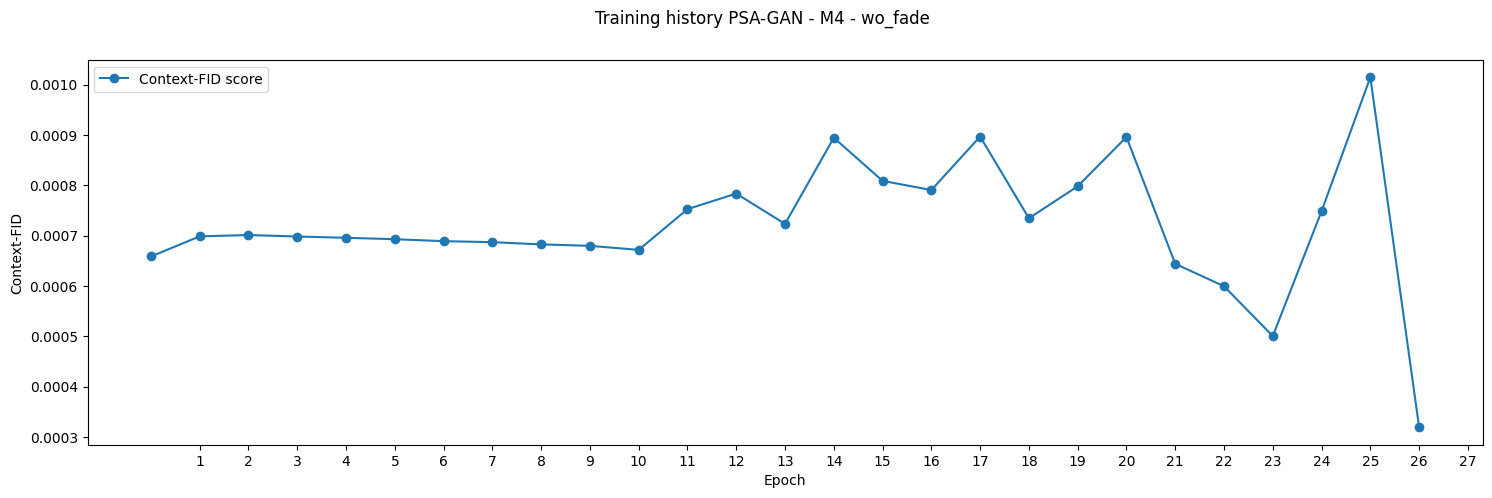

In [11]:
%%time

name_model="wo_fade"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=347,
    discriminator_lr=0.0005,
    generator_lr=0.0005,
    num_epochs=12,
    blocks_to_add=2,
    timestamp=4,
    ml=True,
    fade_in=False,
    sa=True,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)

100%|██████████| 121/121 [00:05<00:00, 23.13it/s]


wo_fade  NRMSE: 0.02389761433005333


100%|██████████| 121/121 [01:13<00:00,  1.64it/s]

FID = 0.00018963112883186838 +- 0.00018963112883186838  
std: 0.0
NRMSE on test set:  tensor(3.1854)


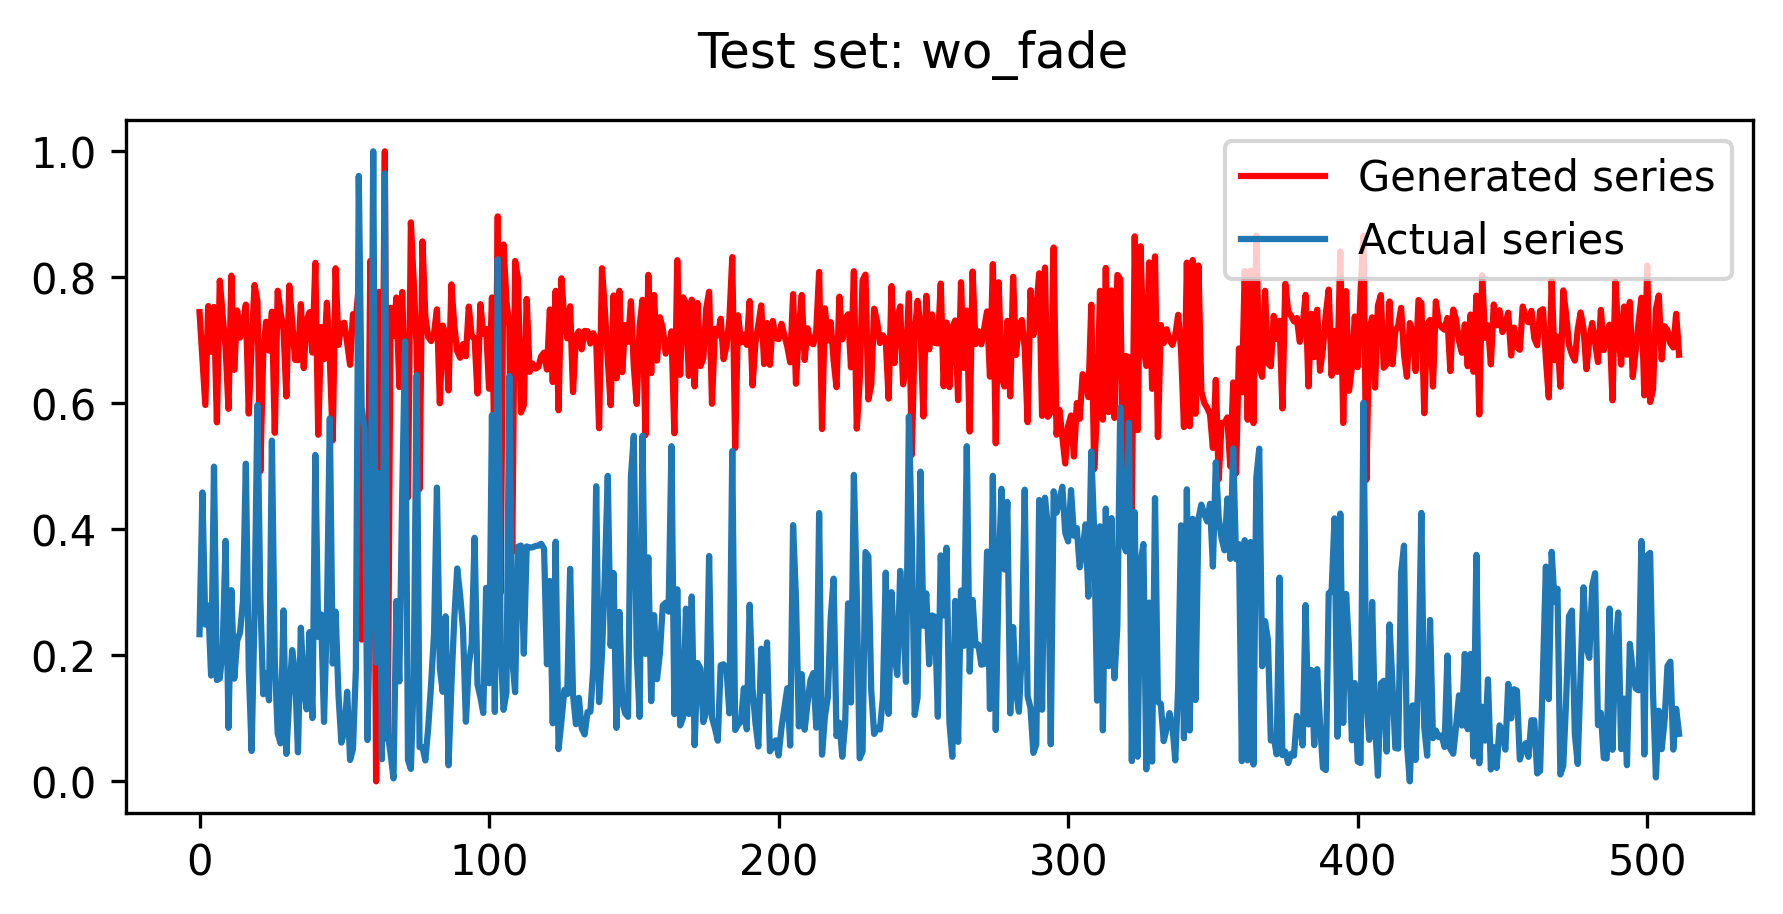

In [12]:

nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper," \nstd:",std_dev)

plotting.prediction_test(seq_length, 347, test_set, testX, G, name_model)

In [13]:
utils.free_gpu(G)

## w/o  ML

In [14]:
%%time

name_model="wo_ml"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=347,
    discriminator_lr=0.0005,
    generator_lr=0.0005,
    num_epochs=12,
    blocks_to_add=2,
    timestamp=4,
    ml=False,
    fade_in=True,
    sa=True,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)

Cuda enabled: using GPU
Directory already exists: Models/M4/wo_ml/

Starting training: wo_ml
Total Epochs: 27 
Blocks to add with fade: 2
Timestamp to add blocks: 9
Fade-in True
ML False
SA True
[Epoch 1/27] [Batch 1/121] [D loss: 1.080802] [G loss: 0.998419] [Fade-in: 1.000000] [FID: 0.000196]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 2/121] [D loss: 0.998004] [G loss: 0.968263] [Fade-in: 1.000000] [FID: 0.000115]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 3/121] [D loss: 0.968505] [G loss: 0.939485] [Fade-in: 1.000000] [FID: 0.000179]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 4/121] [D loss: 0.940422] [G loss: 0.913432] [Fade-in: 1.000000] [FID: 0.000193]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 5/121] [D loss: 0.915393] [G loss: 0.908115] [Fade-in: 1.000000] [FID: 0.000150]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 6/121] [D loss: 0.910329] [G loss: 0.906949] [Fade-in: 1.000000] [FID: 0.000239]
Improvement-Detected, model s

In [ ]:

nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper," \nstd:",std_dev)

plotting.prediction_test(seq_length, 347, test_set, testX, G, name_model)

In [ ]:
utils.free_gpu(G)

## w/o  ML and Fade-in

In [ ]:
%%time

name_model="wo_ml_fade"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=347,
    discriminator_lr=0.0005,
    generator_lr=0.0005,
    num_epochs=12,
    blocks_to_add=2,
    timestamp=4,
    ml=False,
    fade_in=False,
    sa=True,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)

In [ ]:
nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper," \nstd:",std_dev)

plotting.prediction_test(seq_length, 347, test_set, testX, G, name_model)

In [ ]:
utils.free_gpu(G)

## w/o SA

In [ ]:
%%time

name_model="wo_sa"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=347,
    discriminator_lr=0.0005,
    generator_lr=0.0005,
    num_epochs=12,
    blocks_to_add=2,
    timestamp=4,
    ml=True,
    fade_in=True,
    sa=False,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)


In [ ]:
nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper," \nstd:",std_dev)

plotting.prediction_test(seq_length, 347, test_set, testX, G, name_model)

In [ ]:
utils.free_gpu(G)

## w/o SA and fade

In [ ]:
%%time

name_model="wo_sa_fade"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=347,
    discriminator_lr=0.0005,
    generator_lr=0.0005,
    num_epochs=12,
    blocks_to_add=2,
    timestamp=4,
    ml=True,
    fade_in=False,
    sa=False,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)


In [ ]:
nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper," \nstd:",std_dev)

plotting.prediction_test(seq_length, 347, test_set, testX, G, name_model)

In [ ]:
utils.free_gpu(G)

## w/o SA and ML

In [ ]:
%%time

name_model="wo_sa_fade"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=347,
    discriminator_lr=0.0005,
    generator_lr=0.0005,
    num_epochs=12,
    blocks_to_add=2,
    timestamp=4,
    ml=False,
    fade_in=True,
    sa=False,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)

In [ ]:
nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper," \nstd:",std_dev)

plotting.prediction_test(seq_length, 347, test_set, testX, G, name_model)

In [ ]:
utils.free_gpu(G)

## w/o SA and ML and Fade

In [ ]:
%%time

name_model="wo_sa_fade"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=347,
    discriminator_lr=0.0005,
    generator_lr=0.0005,
    num_epochs=12,
    blocks_to_add=2,
    timestamp=4,
    ml=False,
    fade_in=False,
    sa=False,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)

In [ ]:
nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper," \nstd:",std_dev)

plotting.prediction_test(seq_length, 347, test_set, testX, G, name_model)

In [ ]:
utils.free_gpu(G)